In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sys
import os
import seaborn as sns
import pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import torchmetrics
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassAUROC,
    MulticlassF1Score,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassJaccardIndex
)
from argparse import Namespace

current_dir = os.getcwd()
src_dir = os.path.join(current_dir, '..')

if src_dir not in sys.path:
    sys.path.append(src_dir)

from src.data.classification import TumorClassificationDataset
from src.enums import DataSplit
from src.models.classification.resnet import MultiResNetClassifier
from src.utils.config import get_device
from src.trainer import train_classification, eval_classification
from src.utils.visualize import create_classification_results

In [2]:
DATASETS_ROOT = os.path.join(current_dir, '..', 'datasets')
BATCH_SIZE = 32

# Define the transformation pipeline for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),  # Convert images to tensor
    # Add any other transforms here, e.g., normalization
])

device = get_device()
NUM_CLASSES = 4

MULTI_MODEL_PATH = os.path.join(src_dir, 'model_registry', 'tumor_resnetmulticlassifier.pth')

In [3]:
# Step 1: Prepare the Data
train_dataset = TumorClassificationDataset(root_dir=DATASETS_ROOT, split=DataSplit.TRAIN, transform=transform)
test_dataset = TumorClassificationDataset(root_dir=DATASETS_ROOT, split=DataSplit.TEST, transform=transform)

# Define data loaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
# Step 2: Define the Model
model = MultiResNetClassifier(num_classes=NUM_CLASSES)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# train_classification(model, train_loader, optimizer, criterion, device, n_epochs=10, is_multiclass=True, model_path=MULTI_MODEL_PATH)

In [5]:
#load model
model = MultiResNetClassifier(num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(MULTI_MODEL_PATH))
model.to(device)

MultiResNetClassifier(
  (model): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer0): Sequential(
      (0): ResidualBlock(
        (conv1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (conv2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU()
      )
      (1): ResidualBlock(
        (conv1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

In [6]:
metrics = torchmetrics.MetricCollection(
    [
        MulticlassAUROC(NUM_CLASSES).to(device),
        MulticlassJaccardIndex(NUM_CLASSES).to(device),
        MulticlassAccuracy(NUM_CLASSES).to(device),
        MulticlassF1Score(NUM_CLASSES).to(device),
        MulticlassPrecision(NUM_CLASSES).to(device),
        MulticlassRecall(NUM_CLASSES).to(device),
    ]
)

# Step 5: Evaluation
# Set the model to evaluation mode. This affects layers like dropout and batchnorm.
# Disable gradient computation since we don't need it for evaluation
with torch.no_grad():
    # Iterate over the batches of images and labels in the test data loader
    y_true, y_pred, total_metrics = eval_classification(model, test_loader, criterion, metrics, device, is_multiclass=True)
        
# Compute the accuracy as the percentage of correctly classified images
print(f'Accuracy of the network on the test images: {total_metrics["MulticlassAccuracy"]:.2%}')  

  0%|          | 0/41 [00:00<?, ?it/s]/home/jhrudd/miniconda3/envs/ai_project_env/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/jhrudd/miniconda3/envs/ai_project_env/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
100%|██████████| 41/41 [00:04<00:00,  9.68it/s]

Validation Metrics:  {'MulticlassAUROC': tensor(0.9960, device='cuda:0'), 'MulticlassJaccardIndex': tensor(0.8981, device='cuda:0'), 'MulticlassAccuracy': tensor(0.9435, device='cuda:0'), 'MulticlassF1Score': tensor(0.9456, device='cuda:0'), 'MulticlassPrecision': tensor(0.9486, device='cuda:0'), 'MulticlassRecall': tensor(0.9435, device='cuda:0')}
Accuracy of the network on the test images: 94.35%


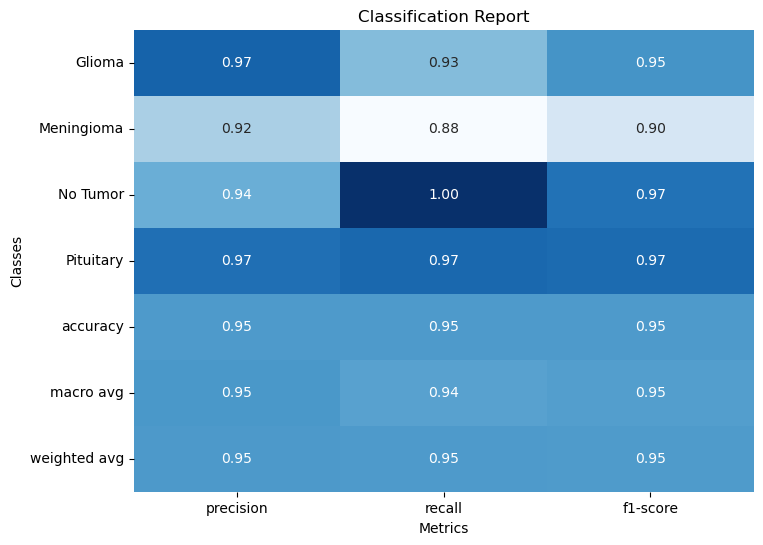

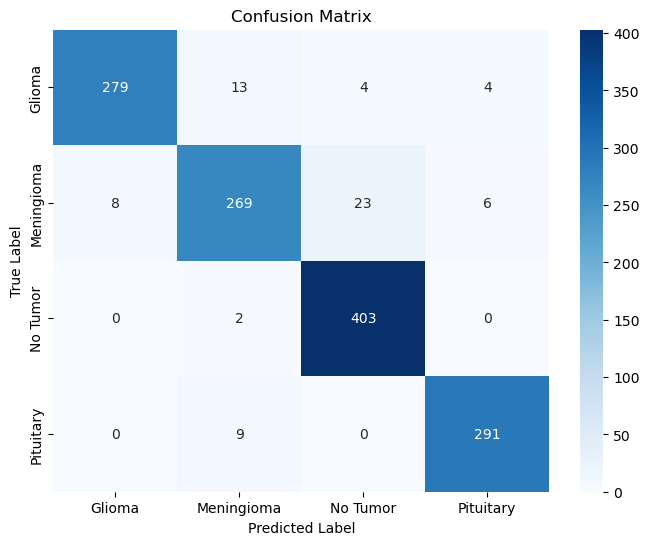

In [7]:
# Convert classification report to dictionary for seaborn heatmap
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
create_classification_results(y_true, y_pred, class_names)